# PyData ML Showcase <img src="/files/novatec.png" style="height: 40px; float: right; position: absolute; top: 10px; right: 0px;">

In this notebook we 

1. extract image features from the webcam
2. train on very few examples to recognize things
3. recognize things in the live camera view


In [1]:
# Necessary Imports
%matplotlib inline

# always needed
import numpy as np
np.set_printoptions(edgeitems=2)

# image related
from ipywebrtc import CameraStream, ImageRecorder
import io
import PIL.Image

# output related
import matplotlib.pyplot as plt
from ipywidgets import widgets, Label, HTML

# ML related
from keras import applications
from sklearn import svm, neighbors

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Set Up

We make use of [ipywebrtc](https://ipywebrtc.readthedocs.io/en/latest/) to send images securely from the browser to the python kernel. In theory, this means that even Android/iOS devices can directly capture images and send them to this notebook.
The CameraStream is only MediaStream in the Browser and not sent to the server, only single images from the ImageRecorder are transmitted.

In [3]:
#from ipywebrtc import CameraStream, ImageRecorder

# Create a MediaStream from the webcam. Contraints are passed on to the browser's getUserMedia()
# the video size set here, will define the image size of the captured and displayed image throughout this notebook
# if you change the video size, close and reopen this notebook to reinitialise the webcam
camera = CameraStream(
    constraints = { 'video': { 'width': 224, 'height': 224 } } 
)
#camera

# this will create controls to capture the webcam images
image_recorder = ImageRecorder(stream=camera)
image_recorder

# please push the camera button, which will appear below when you run this cell, 
# at least once before continuing with the rest of the notebook!

ImageRecorder(image=Image(value=b''), stream=CameraStream(constraints={'video': {'width': 224, 'height': 224}}…

### Obtain  Image 
The last captured image is available PNG encoded in the `image` property of the `ImageRecorder`.
The [Python Image Library](https://pillow.readthedocs.io/en/stable/) can decode it and the [BytesIO](https://docs.python.org/3/library/io.html) enables file like (i.e. random) access to the byte content.

<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=224x224 at 0x7F694FB31DD8>


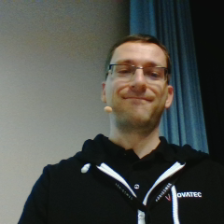

(224, 224, 4)
[[[109 113 116 255]
  [104 107 110 255]
  ...
  [ 10  10  10 255]
  [ 10  10  10 255]]

 [[105 110 112 255]
  [106 110 112 255]
  ...
  [ 10  10  10 255]
  [ 10  10  10 255]]

 ...

 [[168 167 160 255]
  [168 167 160 255]
  ...
  [ 15  17  14 255]
  [ 14  16  13 255]]

 [[172 170 164 255]
  [168 167 160 255]
  ...
  [ 15  17  14 255]
  [ 15  17  14 255]]]


In [4]:
#import io
#import PIL.Image

img = PIL.Image.open(io.BytesIO(image_recorder.image.value))

print(img)
display(img)

img_array = np.asarray(img, dtype='int')
print(img_array.shape)
print(img_array)

### Feature Extraction

We harness the work that has already been invested into training an image classifier. We take a pretrained neural network provided by [Keras](https://keras.io/applications/#mobilenet) and slice out an intermediate data structure (`include_top=False`) which was very helpfull to classify images into 1000 categories ([Imagenet dataset](http://image-net.org/challenges/LSVRC/2014/browse-synsets)). It should give us a good foundation for our simple task.

This function creates a dense vector which "describes" the image content better than the raw pixel data.

In [6]:
#from keras import applications

# download the model that was pretrained on many images and many classes
cnn = applications.mobilenet.MobileNet(
    include_top=False, 
    weights='imagenet', 
    input_shape=(224, 224, 3), 
    pooling = 'avg')

# convert the pixel data into a semantically rich feature vector
def extract_features(img):
    img_array = np.asarray(img, dtype='int')
    img_wo_alpha = img_array[:,:,:3] # remove the alpha channel (4th channel in 3rd dimension)
    img_wo_alpha = applications.mobilenet.preprocess_input(img_wo_alpha) # scale to range [-1;1]
    return cnn.predict(np.array([img_wo_alpha])) # wrap into additiobal array: (224,224,3) -> (1,224,224,3)

# test function:
print(extract_features(img))
print("extracted", extract_features(img).shape, "features from", img_array.size, "values")

[[1.2922972  0.25007382 ... 0.02326867 1.8631402 ]]
extracted (1, 1024) features from 200704 values


# Training

We will use the above functions to capture some trainings images, extract the features and train a very simple classifier


In [7]:
# reset our training data to empty arrays of the correct size
X = np.ndarray((0,1024))
Y = np.ndarray((0,))

print(X.shape)
print(Y.shape)

(0, 1024)
(0,)


### Collect Images

As a widget, `ImageRecorder`'s properties are observable [Traitlets](https://traitlets.readthedocs.io/en/stable/using_traitlets.html#observe), this allows to register a callback on each value change, which processes the image and stores the features (input) and lables (desired output) into the global variables for the training data.

In [9]:
#from ipywidgets import Label, widgets

label = input("Current Capture Label: ")

training_recorder = ImageRecorder(stream=camera)

outputLabel = Label(value = "")

def collect_callback(change):
    img = PIL.Image.open(io.BytesIO(change.new))
    x = extract_features(img)
    y = label
    global X
    global Y
    X = np.append(X, x, axis=0)
    Y = np.append(Y, y)
    classes, counts = np.unique(Y, return_counts=True)
    outputLabel.value = str([": ".join((str(a),str(b))) for a,b in zip(classes, counts)])

training_recorder.image.observe(collect_callback, 'value')

display(training_recorder, outputLabel)

Current Capture Label: down


ImageRecorder(image=Image(value=b''), stream=CameraStream(constraints={'video': {'width': 224, 'height': 224}}…

Label(value='')

### Train Classifier

Because the feature extractor is doing most of the work, the actual classificator is very simple and quick to update

down


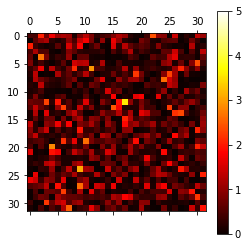

up


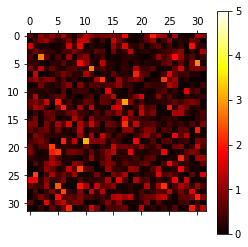

In [11]:
#from sklearn import svm, neighbors
#import matplotlib.pyplot as plt
#%matplotlib inline

# you can try these two classification models by uncommenting them 
classification_model = neighbors.KNeighborsClassifier(n_neighbors=6)
# classification_model= svm.SVC(gamma='scale', decision_function_shape='ovo', probability=True)

classification_model.fit(X, Y)

# additionally we can calculate an average of all veature vectors for each class just for the fun of it.
for clazz in np.unique(Y):
    print(clazz)
    plt.matshow(np.reshape(np.average(X[Y == clazz],axis=0), (32,32)), cmap='hot', vmin=0, vmax=5)
    plt.colorbar()
    plt.show()


# Use
Here, we define a function that uses the trained classifier on a new image by *repeating the same preprocessing steps* and predicting the best fitting label. It returns not only the label, but also the probability and the extracted feature vector.

In [12]:
def classify(image):
    feature_vector = extract_features(image)
    prediction = classification_model.predict(feature_vector)
    prediction_proba = np.max(classification_model.predict_proba(feature_vector))
    return prediction[0], prediction_proba, feature_vector

classify(img)

('up',
 0.8333333333333334,
 array([[1.2922972 , 0.25007382, ..., 0.02326867, 1.8631402 ]],
       dtype=float32))

## Bring everything together
In the following, we combine all of the above to classify the camera image in real-time. Using a callback on the webcam's value change events, we classify one image and after we are done we ask for the next one. After clicking on the camera icon you will see the recorded image and the result as a text below the images.

You can stop the process with the stop sign button. After that you have to execute the cell again to repeat the process.

In [13]:
from ipywidgets import widgets, HTML

# in- and output 
inference_recorder = ImageRecorder(stream=camera)
resultLabel = widgets.HTML()
button = widgets.Button(description='Stop', icon="stop-circle")

# abort button
proceed = True
def stop_callback(event):
    global proceed
    proceed = False
button.on_click(stop_callback)

# computation
def inference_callback(change):
    img = PIL.Image.open(io.BytesIO(change.new))
    result, conf, feature_vector = classify(img)
    resultLabel.value = "<h2>I see <strong>&quot;{}&quot;</strong> and I'm <strong>{:0.2f}%</strong> certain about it</h2>".format(result, conf*100)

    if (proceed):
        inference_recorder.recording = True

inference_recorder.image.observe(inference_callback, 'value')

# combine it into one cell 
widgets.VBox([button, inference_recorder, resultLabel])

if you want your webcam to stop recording, you have to close this browser tab.


## Reproducibility Info

In [ ]:
!pip install watermark

In [16]:
%load_ext watermark
%watermark -v -iv

sklearn    0.20.3
ipywidgets 7.4.2
numpy      1.16.4
PIL        5.4.1
keras      2.2.4
matplotlib 2.2.3
CPython 3.6.8
IPython 7.2.0


### Bonus

In [15]:
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
__________

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 32 samples in 0.000s...
[t-SNE] Computed neighbors for 32 samples in 0.017s...
[t-SNE] Computed conditional probabilities for sample 32 / 32
[t-SNE] Mean sigma: 5.363187
[t-SNE] KL divergence after 250 iterations with early exaggeration: 46.937176
[t-SNE] KL divergence after 1000 iterations: 0.402210


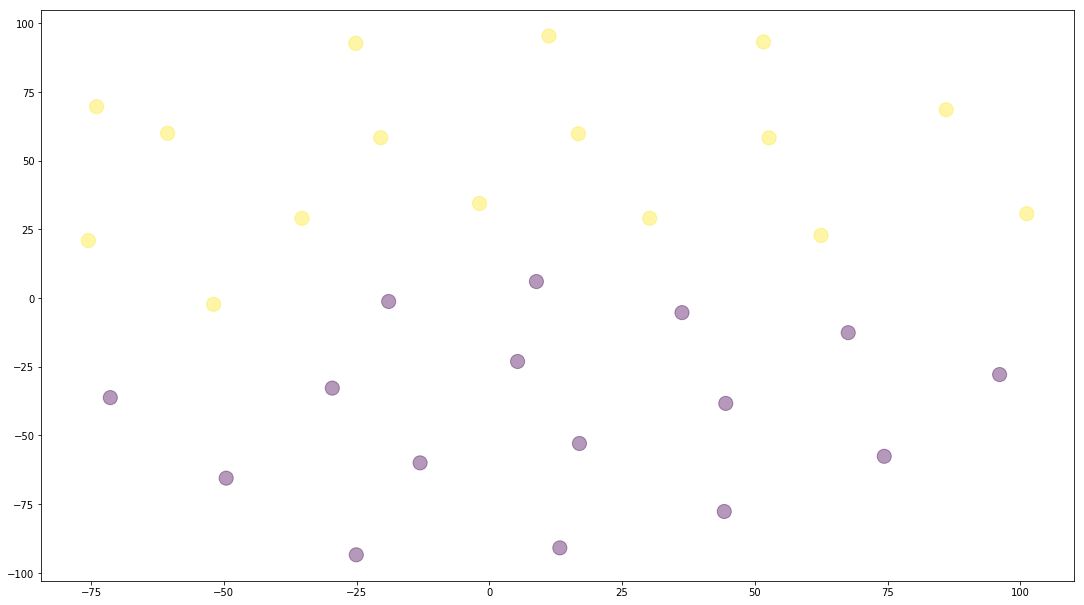

In [14]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, verbose=True).fit_transform(X)
c = list(map(lambda y: list(np.unique(Y)).index(y),Y))
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=c, alpha=0.4, s=200)